In [1]:
import numpy as np
import scipy
import scipy.signal

%load_ext tikzmagic

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

!pip install git+https://github.com/veeresht/CommPy.git > /dev/null

import commpy
matplotlib.rcParams['axes.ymargin'] = 0.1
matplotlib.rcParams['axes.xmargin'] = 0.0

# Baseband signal upconversion and IQ Modulation and Demodulation

In this article, we will go through the basic steps of the up- and downconversion of a baseband signal to the passband signal. In most digital signal processing devices, any signal processing is performed in the baseband, i.e. where the signals are centered around the DC frequency. These baseband signals are mainly complex-valued. However, only real-valued signals can be sent with real-world physical devices. The process of upconversion thus has two purposes:

1. Convert the complex-valued baseband signal to a real-valued signal which can be transmitted over an antenna, cable or similar.
2. Adapt the transmit signal such that it uses a specific frequency band of the physical channel. This way, multiple signals can be transmitted independently on different frequency bands.

At the receiver, the received signal is then downconverted to baseband such that the subsequent processing can be done in complex-valued baseband domain.

A generic digital transceiver system with digital baseband processing, analog to digital conversion and up- and downconversion is presented in the figure below:

%%tikz -l positioning --size 800,600

\tikzset{mul/.style={draw,circle,inner sep=1pt}}
\tikzset{>=latex}

\begin{scope}[xshift=1cm]
\draw [double,->] (0,0) node [left] (d) {$d[k]$} -- +(1,0) node [right,mul] (M1) {$\times$};
\draw [double,->] (M1.east) -- +(1,0) node (g1) [draw,right] {$g(t)$} node [midway,above] {$x(t)$};
\draw [double,->] (g1.east) -- +(1,0) node (R1) [draw,right,align=center, minimum height=1.5cm] {Re\\Im} node [midway,above] {$u(t)$};

\node (P) [mul,right=3 of R1] {$+$};
\draw [->] (R1.55) -- +(1,0) node (MC1) [right,mul] {$\times$} node [midway,above] {$i(t)$};
\draw [->] (R1.-55) -- +(1,0) node (MS1) [right,mul] {$\times$} node [midway,above] {$q(t)$};
\draw [->] (MC1.east) -| (P) node [pos=0.25,above] {$i_{up}(t)$};
\draw [->] (MS1.east) -| (P) node [pos=0.25,above] {$q_{up}(t)$};
\draw [->] (P.east) -- +(1,0) node [right] {$s(t)$};
\draw [->] ([yshift=-0.7cm]M1.south) node [below] {$\sum_n\delta(t-nT)$} -- (M1.south);
\draw [->] ([yshift=0.4cm]MC1.north) node [above] {$\cos(2\pi f_c t)$} -- (MC1.north);
\draw [->] ([yshift=-0.2cm]MS1.south) node [below] {$-\sin(2\pi f_c t)$} -- (MS1.south);
\draw [dashed,red] ([yshift=-0.8cm,xshift=-0.8cm]d.center) -- ++(1.6,0) -- ++(0,1.6) -- ++(-1.6,0) node [pos=0.8,above] {Digital baseband};
\draw [dashed,blue] ([yshift=0.8cm,xshift=-0.6cm]M1.center) rectangle ([xshift=0.5cm,yshift=-0.8cm]g1.center) node [midway,above,yshift=0.8cm] {D/A Conversion};

\node (T1) [below=1.5 of d.center] {T1)};
\node at (T1-|M1.center) {T2)};
\node at (T1-|g1.center) {T3)};
\node at (T1-|R1.center) {T4)};
\node at (T1-|MC1.center) {T5)};
\node at (T1-|P.center) {T6)};

\draw [dashed] ([yshift=-0.5cm]T1.center)+(-1,0) -- ++(12,0);
\end{scope}



\begin{scope}[yshift=-4.5cm]
\draw [->] (0,0) node [left] (s) {$s(t)$} -- ++(0.5,0) coordinate (C) |- ++(0.5,0.7) node (MC2) [right,mul] {$\times$};
\draw [->] (C) |- ++(0.5,-0.7) node (MS2) [right,mul] {$\times$};
\draw [->] (MC2.east) -- +(1.5,0) node (LP1) [draw,right] {LP} node [midway,above] {$i_{down}(t)$};
\draw [->] (MS2.east) -- +(1.5,0) node (LP2) [draw,right] {LP} node [midway,above] {$q_{down}(t)$};
\node (R2) [right=5 of C,draw,minimum height=2cm,align=center] {Re\\Im};
\draw [->] (LP1.east) -- (LP1.east-|R2.west) node [midway,above] {$i_{down,LP}(t)$};
\draw [->] (LP2.east) -- (LP2.east-|R2.west) node [midway,above] {$q_{down,LP}(t)$};
\draw [double,->] (R2.east) -- +(1,0) node (g2) [right,draw] {$g(t)$} node [midway,above] {$v(t)$};
\draw [double,->] (g2.east) -- +(1,0) node (S) [right,draw] {\tikz[-,scale=0.2]\draw (0,0) -- ++(1,0) -- ++(1,1) ++(0,-1) -- ++(1,0);} node [midway,above] {$y(t)$};
\draw [double,->] (S.east) -- +(1,0) node (dh) [right] {$\hat{d}[k]$};
\draw [fill] (C) circle (1pt);
\draw [->] ([yshift=0.5cm]MC2.north) node [above] {$\cos(2\pi f_c t)$} -- (MC2.north);
\draw [->] ([yshift=-0.5cm]MS2.south) node [below] {$-\sin(2\pi f_c t)$} -- (MS2.south);
\draw [->] (S.north)+(0,0.27) node [above,yshift=-0.1cm] {$T$} -- (S);
\draw [dashed,blue] ([xshift=-0.5cm,yshift=0.8cm]g2.center) rectangle ([xshift=0.5cm,yshift=-0.8cm]S.center) node [midway,above,yshift=0.8cm] {A/D Conversion};
\draw [dashed,red] ([xshift=0.8cm,yshift=-0.8cm]dh.center) -- ++(-1.6,0) -- ++(0,1.6) -- ++(1.6,0) node [pos=0.8,above] {Digital baseband};

\node (R1) at  ([yshift=-1.7cm]MS2.center) {R1)};
\node at (R1-|LP1.center) {R2)};
\node at (R1-|R2.center) {R3)};
\node at (R1-|g2.center) {R4)};
\node at (R1-|S.center) {R5)};
\end{scope}


In the following steps, we will go through the components and numerically illustrate, what happens within these blocks. Let us first define some variables and constants:

In [3]:
Fs = int(6e4)    # the sampling frequency we use for the discrete simulation of analog signals

fc = int(3e3)    # 3kHz carrier frequency
Ts = 1e-3        # 1 ms symbol spacing, i.e. the baseband samples are Ts seconds apart.
BN = 1/(2*Ts )   # the Nyquist bandwidth of the baseband signal.


ups = int(Ts*Fs) # number of samples per symbol in the "analog" domain
N = 10           # number of transmitted baseband samples

In [3]:
Fs = int(6e4)    # the sampling frequency we use for the discrete simulation of analog signals

fc = int(3e3)    # 3kHz carrier frequency
Ts = 1e-3        # 1 ms symbol spacing, i.e. the baseband samples are Ts seconds apart.
BN = 1/(2*Ts )   # the Nyquist bandwidth of the baseband signal.


ups = int(Ts*Fs) # number of samples per symbol in the "analog" domain
N = 10           # number of transmitted baseband samples

Let us further define our transmit filter $g(t)$. In our case, we use a root-raised cosine (RRC) filter with rolloff 1. *Feel free to change the filter or rolloff for your own experiments.* Since the normal RRC filter is infinitely long in time domain, we need to truncate it to a length of $2t_0$ and make it causal by shifting it by $t_0$ to the right:

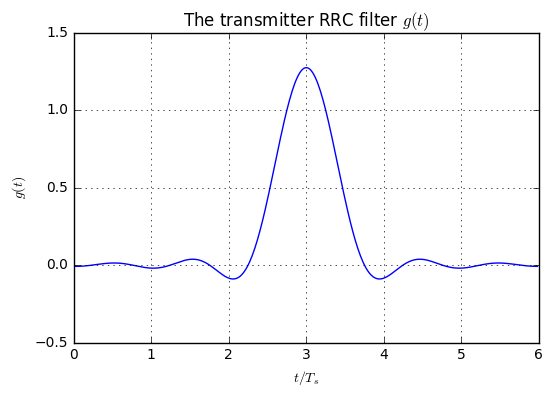

In [4]:
# the RRC filter should span 3 baseband samples to the left and to the right. 
# Hence, it introduces a delay of 3Ts seconds.
t0 = 3*Ts  


# Calculate the filter coefficients (N=number of samples in filter)
_, rrc = commpy.filters.rrcosfilter(N=int(2*t0*Fs), alpha=1,Ts=Ts, Fs=Fs)
t_rrc = np.arange(len(rrc)) / Fs  # the time points that correspond to the filter values
plt.plot(t_rrc/Ts, rrc)
plt.grid(True); plt.ylabel('$g(t)$'); plt.xlabel('$t/T_s$'); plt.title('The transmitter RRC filter $g(t)$');

## The Transmitter (Steps T1-T6)

In step T1) we generate some random baseband data. The baseband of the digital transmission system can be complex-valued, so we create complex baseband samples $d[n]$. 

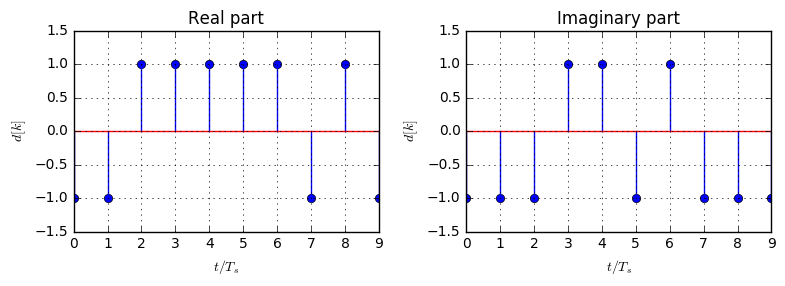

In [5]:
# Step T1)
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j])  # the possible values in the baseband
dk = np.random.choice(constellation, size=(N))        # randomly choose some samples
t_symbols = Ts * np.arange(N)                         # time instants of the baseband samples

# Plot the samples
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.stem(t_symbols/Ts, dk.real);
plt.grid(True); plt.ylabel('$d[k]$'); plt.xlabel('$t/T_s$'); plt.title('Real part');
plt.subplot(122)
plt.stem(t_symbols/Ts, dk.imag);
plt.grid(True); plt.ylabel('$d[k]$'); plt.xlabel('$t/T_s$'); plt.title('Imaginary part');
plt.tight_layout();

The next step T2) in the signal processing chain is the weighting of a Dirac comb function with the baseband samples, yielding the signal $x(t)$, given by
$$x(t)=\sum_{k=-\infty}^{\infty}d[k]\delta(t-kT_s).$$ We emulate this by creating a sequence of zeros $x$, where at each time for a new baseband sample, this sample is written into the sequence:

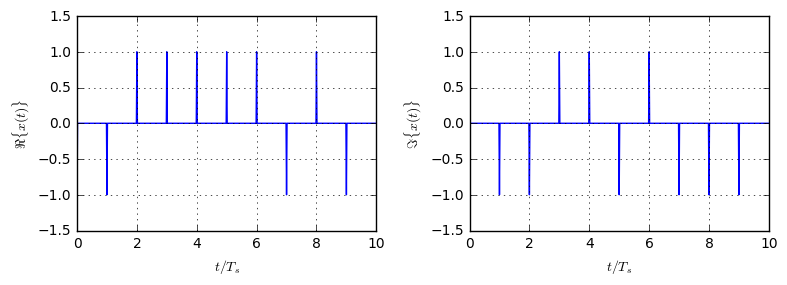

In [6]:
# Step T2)
x = np.zeros(ups*N, dtype='complex')
x[::ups] = dk  # every ups samples, the value of dn is inserted into the sequence
t_x = np.arange(len(x))/Fs

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t_x/Ts, x.real);
plt.grid(); plt.ylabel(r'$\Re\{x(t)\}$'); plt.xlabel('$t/T_s$');
plt.subplot(122)
plt.plot(t_x/Ts, x.imag);
plt.grid(); plt.ylabel(r'$\Im\{x(t)\}$'); plt.xlabel('$t/T_s$');
plt.tight_layout();

In step T3), the weighted Dirac comb function is filtered with the pulse shaping filter $g(t)$. The outcome is the baseband signal $u(t)$, given by $$u(t)=g(t)*x(t)=\sum_{k=-\infty}^{\infty}d[k]g(t-kT_s).$$

In the code below, we calculate the filtering by using `np.convolve`. For the plotting of the signal, we also plot the corresponding weighted Dirac comb in the figures. However, since the filtering introduces a delay of $t_0$ seconds, we also delay $x(t)$ by $t_0$ to match it to the transmitted signal:

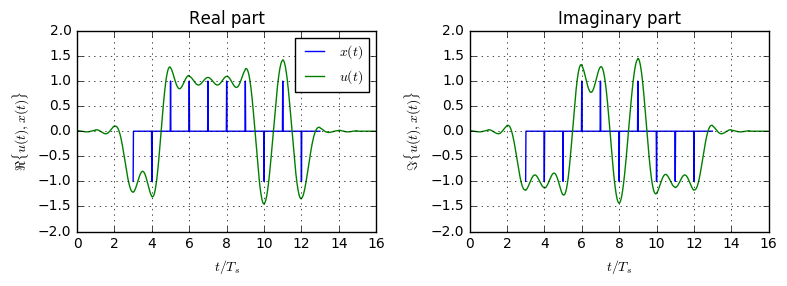

In [7]:
# Step T3)
u = np.convolve(x, rrc)

t_u = np.arange(len(u))/Fs

plt.figure(figsize=(8,3))
plt.subplot(121)  
plt.plot((t_x+t0)/Ts, x.real, label='$x(t)$') # artificial extra delay for the baseband samples
plt.plot(t_u/Ts, u.real, label='$u(t)$')
plt.grid(True); plt.ylabel(r'$\Re\{u(t),x(t)\}$'); plt.xlabel('$t/T_s$'); plt.title('Real part'); plt.legend(fontsize=10);
plt.subplot(122)
plt.plot((t_x+t0)/Ts, x.imag)
plt.plot(t_u/Ts, u.imag)
plt.grid(True); plt.ylabel(r'$\Im\{u(t),x(t)\}$'); plt.xlabel('$t/T_s$'); plt.title('Imaginary part');
plt.tight_layout();

As we see, the baseband signal roughly matches the transmitted baseband samples. Since we use an RRC filter, the signal is not ISI-free and hence the baseband signal does not exactly go through the values of the baseband samples. We will use a matched filter at the receiver to get the correct samples out of this signal.

In the next step T4), the complex baseband signal $u(t)$ is split into real and imaginary part. The real and imaginary part are also named in-phase (I) and quadratur (Q) components.

In [8]:
# Step T4)
i = u.real
q = u.imag

The interesting part of up-conversion happens in step T5). Here, the real and imaginary part of the signal are multiplied by cosine and sine, respectively:

$$\begin{align}
i_{up}(t)&=i(t)\cos(2\pi f_c t)\\
q_{up}(t)&=-q(t)\sin(2\pi f_c t)
\end{align}.$$

In [9]:
# Step T5)
iup = i * np.cos(2*np.pi*t_u*fc)  
qup = q * -np.sin(2*np.pi*t_u*fc)

Let us see how these signal look like, and also what we can learn from their spectrum, i.e. Fourier transform:

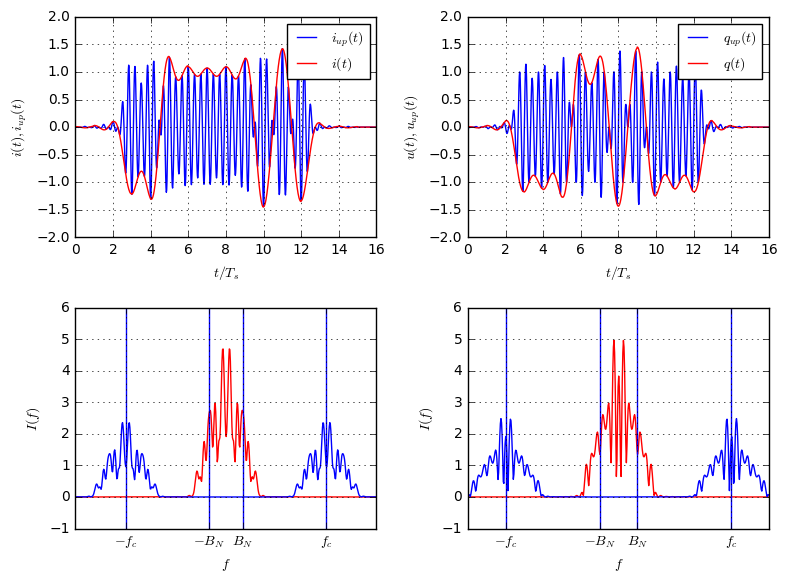

In [10]:
# define a function to calculate the spectrum of a signal
fftLen = 4*len(u)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / Fs * (len(u))

# Calculate the spectrum of the signals
f_u = np.linspace(-Fs/2, Fs/2, fftLen)
I = spectrum(i); Iup = spectrum(iup)
Q = spectrum(q); Qup = spectrum(qup)

# Plot the time-domain signals
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(t_u/Ts, iup, label='$i_{up}(t)$')
plt.plot(t_u/Ts, i, 'r', label='$i(t)$')
plt.xlabel('$t/T_s$'); plt.ylabel('$i(t), i_{up}(t)$'); plt.legend(fontsize=10);
plt.grid(True);

plt.subplot(222)
plt.plot(t_u/Ts, qup, label='$q_{up}(t)$')
plt.plot(t_u/Ts, q, 'r', label='$q(t)$')
plt.xlabel('$t/T_s$'); plt.ylabel('$u(t), u_{up}(t)$'); plt.legend(fontsize=10);
plt.grid(True);

plt.subplot(223)
plt.plot(f_u, abs(I), 'r')
plt.plot(f_u, abs(Iup), 'b')
plt.xlim((-fc-3*BN, fc+3*BN))
plt.axvline(fc); plt.axvline(-fc)
plt.axvline(-BN); plt.axvline(BN)
plt.xticks([-fc, -BN, BN, fc])
plt.gca().set_xticklabels(['$-f_c$', '$-B_N$', '$B_N$', '$f_c$']);
plt.grid(True); plt.ylabel('$I(f)$'); plt.xlabel('$f$');

plt.subplot(224)
plt.plot(f_u, abs(Q), 'r')
plt.plot(f_u, abs(Qup), 'b')
plt.xlim((-fc-3*BN, fc+3*BN))
plt.xlim((-fc-2*BN, fc+2*BN))
plt.axvline(fc); plt.axvline(-fc)
plt.axvline(-BN); plt.axvline(BN)
plt.xticks([-fc, -BN, BN, fc])
plt.gca().set_xticklabels(['$-f_c$', '$-B_N$', '$B_N$', '$f_c$']);
plt.grid(True); plt.ylabel('$I(f)$'); plt.xlabel('$f$');
plt.tight_layout();

We can make several observations from these graphs: The blue curves are the upconverted version of the red curves. As shown, their envelope in time domain is given by the red curve. In the spectrum, we see that the blue curves are copies of the red curve, but shifted to the carrier frequency. In particular, note that all spectrums are symmetric. This is clear, since both $i(t)$ and $q(t)$ are purely real functions, which have a symmetric spectrum.

Eventually, in step T6) the I- and Q-path of the signal are summed together to get $s(t)=i_{up}(t)+q_{up}(t)$. Then, $s(t)$ is sent to the antenna.

In [11]:
# Step T6)
s = iup + qup

Let us have a look at the time domain signal $s(t)$ and its spectrum $S(f)$. In addition, let us compare $S(f)$ against the baseband spectrum $U(f)$:

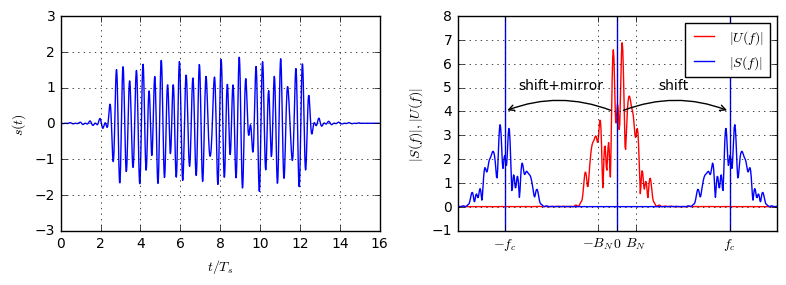

In [12]:
S = spectrum(s)
U = spectrum(u)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t_u/Ts, s)
plt.grid(True); plt.ylabel('$s(t)$'); plt.xlabel('$t/T_s$');

plt.subplot(122)
plt.plot(f_u, abs(U), 'r', label='$|U(f)|$')
plt.plot(f_u, abs(S), 'b', label='$|S(f)|$')
plt.xlim((-fc-2.5*BN, fc+2.5*BN))
plt.xticks([-fc, -BN, 0, BN, fc])
plt.legend(fontsize=10);
plt.gca().set_xticklabels(['$-f_c$', '$-B_N$', '$0$', '$B_N$', '$f_c$']); plt.ylabel('$|S(f)|,|U(f)|$')
plt.axvline(-fc); plt.axvline(0); plt.axvline(fc)
ax = plt.gca()
ax.annotate('', xy=(fc, 4), xytext=(0.2*BN, 4), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.text(fc/2, 4.8, 'shift', ha='center', va='bottom')
ax.annotate('', xy=(-fc, 4), xytext=(-0.2*BN, 4), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.text(-fc/2, 4.8, 'shift+mirror', ha='center', va='bottom')
plt.grid(True)
plt.tight_layout();

From the time-domain signal we cannot really see anything. But, looking at the spectrum we can see the following:
- The blue spectrum $S(f)$ is symmetric (to $f=0$). Hence, it corresponds to a real signal. This is clear, since the signal which is sent to the antenna must be real-valued.
- The red spectrum $U(f)$ is not symmetric, since it corresponds to a complex-valued baseband signal. However, note that the right half of $S(f)$ equals $U(f)$ (up to a scaling factor). The left half of $S(f)$ equals $U(-f)$, i.e. the mirrored baseband spectrum. By this trick, the complex-valued baseband signal $u(t)$ is converted to a real-valued bandpass signal $s(t)$ which carries the same information.

## The Receiver (Steps R1-R5)

At the receiver, in step R1) the signal $s(t)$ is first multiplied by a sine and a cosine to get a down-converted I and Q component, given by
$$\begin{align}
i_{down}(t) &= s(t)\cos(2\pi f_c t)\\
q_{down}(t) &= -s(t)\sin(2\pi f_c t)
\end{align}.$$

In [13]:
# Step R1)
idown = s * np.cos(2*np.pi*-fc*t_u) 
qdown = s * -np.sin(2*np.pi*fc*t_u)

Let us again look at the spectrum of both downconverted signals:

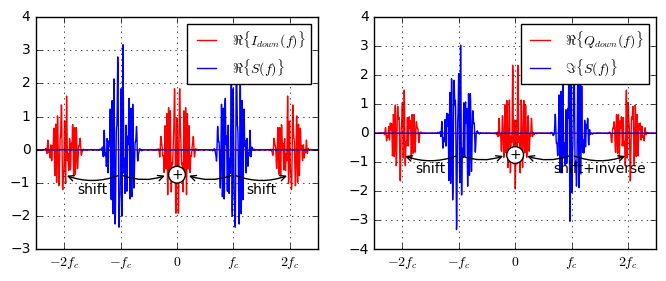

In [14]:
Idown = spectrum(idown)
Qdown = spectrum(qdown)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(f_u, Idown.real, label=r'$\Re\{I_{{down}}(f)\}$', color='r')
plt.plot(f_u, S.real, label='$\Re\{S(f)\}$', color='b')
plt.xlim((-2*fc-3*BN, 2*fc+3*BN))
plt.xticks([-2*fc, -fc, 0, fc, 2*fc]);
plt.gca().set_xticklabels(['$-2f_c$', '$-f_c$', '$0$', '$f_c$', '$2f_c$'])
plt.legend(fontsize=10)
plt.gca().annotate('', xy=(-BN, -0.75), xytext=(-fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.gca().annotate('', xy=(BN, -0.75), xytext=(fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.text(0, -0.75, '+', ha='center', va='center', bbox=dict(facecolor='white', boxstyle='circle,pad=0.1'))
plt.gca().annotate('', xy=(-2*fc, -0.75), xytext=(-fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.gca().annotate('', xy=(2*fc, -0.75), xytext=(fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.text(-1.5*fc, -1, 'shift', va='top', ha='center')
plt.text(1.5*fc, -1, 'shift', va='top', ha='center')
plt.grid(True);

plt.subplot(122)
plt.plot(f_u, Qdown.real, label=r'$\Re\{Q_{{down}}(f)\}$', color='r')
plt.plot(f_u, S.imag, label=r'$\Im\{S(f)\}$', color='b')
plt.gca().annotate('', xy=(-BN, -0.75), xytext=(-fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.gca().annotate('', xy=(BN, -0.75), xytext=(fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.text(0, -0.75, '+', ha='center', va='center', bbox=dict(facecolor='white', boxstyle='circle,pad=0.1'))
plt.gca().annotate('', xy=(-2*fc, -0.75), xytext=(-fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.gca().annotate('', xy=(2*fc, -0.75), xytext=(fc, -0.75), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.text(-1.5*fc, -1, 'shift', va='top', ha='center')
plt.text(1.5*fc, -1, 'shift+inverse', va='top', ha='center')
plt.xlim((-2*fc-3*BN, 2*fc+3*BN))
plt.xticks([-2*fc, -fc, 0, fc, 2*fc]);
plt.gca().set_xticklabels(['$-2f_c$', '$-f_c$', '$0$', '$f_c$', '$2f_c$'])
plt.legend(fontsize=10)
plt.grid(True);

First of all, we see that the downconverted signal has componenents around $f=0$ and some images around $f=2f_c$. Without going deeply into the maths, we can intuitively explain this: The blue signal $s(t)$ is multiplied by a cosine in time domain. This operation equals a convolution in the frequency domain, and the frequency domain expression of a cosine is given by

$$\mathcal{F}\{\cos(2\pi f_c t)\}=\frac{1}{2}(\delta(f-f_c)+\delta(f+f_c)).$$

Hence, we can find the following relation:
$$\begin{align}
i_{down}(t)&=s(t)\cos(2\pi f_c t)\\
I_{down}(f)&=S(f)*\frac{1}{2}(\delta(f-f_c)+\delta(f+f_c))=\frac{1}{2}(S(f-f_c)+S(f+f_c)).
\end{align}
$$

This means, the red spectrum is the sum of shifting the blue spectrum by $f_c$ to the right to the left. Since $S(f)$ is concentrated around $f=\pm f_c$, we first get a component around $f=0$, but also images at $f=2f_c$.

Since we are only interested in the central part of the signal, the images at $2f_c$ need to be eliminated. To this end, we apply a low-pass filter, which is called the *image rejection filter* by obvious reasons. 

Let us design such a filter. Normally, the cutoff should be closely chosen to the bandwidth of the following AD converter in order to eliminate as much noise as possible. However, here we take a more pragmatic approach and design a filter that just rejects the images at $2f_c$. Also note that the filter, to be causal, necessarily introduces some extra delay $\tau_{LP}$ to the signal.

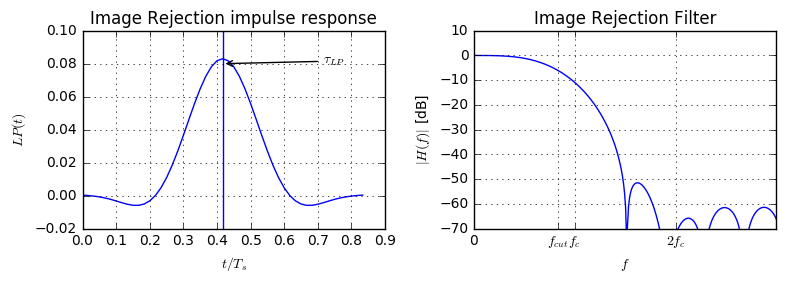

In [15]:
cutoff = 5*BN        # arbitrary design parameters
lowpass_order = 51   
lowpass_delay = (lowpass_order // 2)/Fs  # a lowpass of order N delays the signal by N/2 samples (see plot)
# design the filter
lowpass = scipy.signal.firwin(lowpass_order, cutoff/(Fs/2))

# calculate frequency response of filter
t_lp = np.arange(len(lowpass))/Fs
f_lp = np.linspace(-Fs/2, Fs/2, 2048, endpoint=False)
H = np.fft.fftshift(np.fft.fft(lowpass, 2048))

plt.figure(figsize=(8,3));
plt.subplot(121)
plt.plot(t_lp/Ts, lowpass)
plt.grid(True); plt.ylabel('$LP(t)$'); plt.xlabel('$t/T_s$'); plt.title('Image Rejection impulse response');
plt.axvline(lowpass_delay/Ts);
plt.gca().annotate(r'$\tau_{LP}$', xy=(lowpass_delay/Ts,0.08), xytext=(lowpass_delay/Ts+0.3, 0.08), arrowprops=dict(arrowstyle='->'))

plt.subplot(122)
plt.plot(f_lp, 20*np.log10(abs(H)))
plt.xlim((0, 3*fc))
plt.xticks([0, cutoff, fc, 2*fc])
plt.gca().set_xticklabels(['0', '$f_{cut}$', '$f_c$', '$2f_c$'])
plt.ylabel('$|H(f)|$ [dB]'); plt.xlabel('$f$'); plt.title('Image Rejection Filter')
plt.ylim((-70, 10));
plt.grid(True);
plt.tight_layout();

As we see, the filter will introduce a delay of $\tau_{LP}$ due to its maximum at this time. Furthermore, according to the frequency response, it should reliably remove the images at $2f_c$.

So, in step R2) the images that stem from the downconversion are filtered out by means of the lowpass image rejection filter:
$$\begin{align}
i_{down,lp}(t)&=i_{down}(t)*LP(t)\\
q_{down,lp}(t)&=q_{down}(t)*LP(t)\\
\end{align}.$$

In [16]:
# Step R2) 
idown_lp = scipy.signal.lfilter(lowpass, 1, idown)
qdown_lp = scipy.signal.lfilter(lowpass, 1, qdown)

Let us again have a look at the spectrum of these filtered signals:

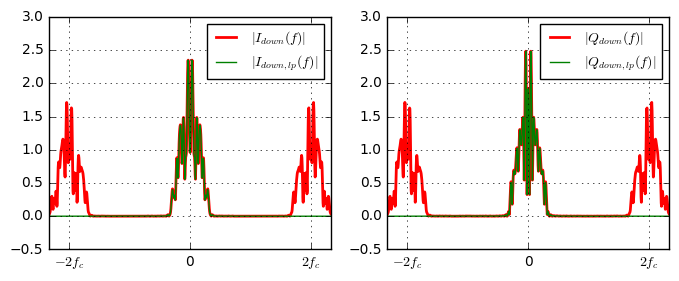

In [17]:
Idown_lp = spectrum(idown_lp)
Qdown_lp = spectrum(qdown_lp)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(f_u, abs(Idown), 'r', lw=2, label=r'$|I_{down}(f)|$')
plt.plot(f_u, abs(Idown_lp), 'g-', label=r'$|I_{down,lp}(f)|$')
plt.xlim((-2*fc-2*BN, 2*fc+2*BN))
plt.legend(fontsize=10); plt.grid(True);
plt.xticks([-2*fc, 0, 2*fc]);
plt.gca().set_xticklabels(['$-2f_c$', '0', '$2f_c$']);

plt.subplot(122)
plt.plot(f_u, abs(Qdown), 'r', lw=2, label=r'$|Q_{down}(f)|$')
plt.plot(f_u, abs(Qdown_lp), 'g', label=r'$|Q_{down,lp}(f)|$')
plt.xlim((-2*fc-2*BN, 2*fc+2*BN))
plt.legend(fontsize=10); plt.grid(True);
plt.xticks([-2*fc, 0, 2*fc]);
plt.gca().set_xticklabels(['$-2f_c$', '0', '$2f_c$']);

As we can see, the image rejection filter has successfully removed the images at $2f_c$ from the signal, since the green curves only have components around $f=0$. Now, we can go ahead and combine I- and Q components to a complex baseband signal in step R3):
$$v(t)=i_{down,lp}(t)+jq_{down,lp}(t).$$

In [18]:
# Step R3)
v = idown_lp + 1j*qdown_lp

In step R4), we perform matched filtering to the transmitter filter $g(t)$. This way the RRC at the transmitter and receiver combine to a RC filter, fulfills the [1st Nyquist criterion](http://dspillustrations.com/pages/posts/misc/the-first-nyquist-criterion.html) and hence yields ISI-free baseband samples, when sampled at the correct sampling position.
$$y(t)=v(t)*g(t)$$


In [19]:
# Step R4)
y = np.convolve(v, rrc) / (sum(rrc**2)) * 2

Here, we introduce some energy normalization to get the correct amplitude of the signal at the receiver. Eventually, in step R5), we sample the analog baseband signal to get the actual baseband samples that were transmitted over the channel. Here, we need to take care of the overall transmission delay of the chain, which consists of

- $t_0$ delay at the transmitter due to filtering with $g(t)$ in the DA conversion,
- $\tau_{LP}$ delay at the receiver due to the image rejection filter,
- $t_0$ delay at the receiver due to matched filtering with $g(t)$ in the AD conversion.

Hence, the overall delay is given by $2t_0+\tau_{LP}$. So, to get the baseband samples, we sample the received baseband signal at the following positions:

$$\hat{d}[n] = v(nT_s+2t_0+\tau_{LP}).$$

In [20]:
# Step R5)
delay = int((2*t0 + lowpass_delay)*Fs)

Let us finally have a look at the resulting baseband signal and the sampled version of it. We can also compare the received values with the transmitted to make sure, our transmission did not introduce any errors.

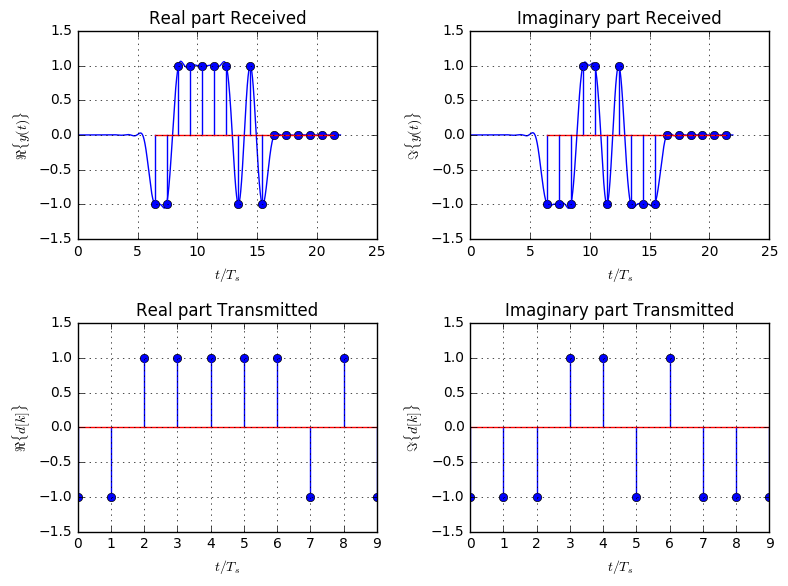

In [22]:
t_y = np.arange(len(y))/Fs
t_samples = t_y[delay::ups]
y_samples = y[delay::ups]

plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(t_y/Ts, y.real)
plt.stem(t_samples/Ts, y_samples.real)
plt.xlabel('$t/T_s$'); plt.ylabel(r'$\Re\{y(t)\}$'); plt.grid(True); plt.title('Real part Received');

plt.subplot(222)
plt.plot(t_y/Ts, y.imag)
plt.stem(t_samples/Ts, y_samples.imag)
plt.xlabel('$t/T_s$'); plt.ylabel(r'$\Im\{y(t)\}$'); plt.grid(True); plt.title('Imaginary part Received');

plt.subplot(223)
plt.stem(t_symbols/Ts, dk.real);
plt.xlabel('$t/T_s$'); plt.ylabel(r'$\Re\{d[k]\}$'); plt.grid(True); plt.title('Real part Transmitted');
plt.subplot(224)
plt.stem(t_symbols/Ts, dk.imag);
plt.xlabel('$t/T_s$'); plt.ylabel(r'$\Im\{d[k]\}$'); plt.grid(True); plt.title('Imaginary part Transmitted');
plt.tight_layout();

As shown, the received samples match the transmitted samples, however a significant delay due to the intermediate filters was introduced.